In [1]:
import argparse
import os
import copy
import time
from enum import Enum
import importlib

import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from torch.utils.data import Subset
import attention
# import webdataset as wds

import datetime
import utils
import numpy as np
import math
import einops
import random
import pandas as pd

import wandb 
import sys 
import glob


In [2]:
parser = argparse.ArgumentParser(description='GMM L2L Training with Sequence Model')
parser.add_argument('--data', metavar='DIR', nargs='?', default='./data',
                    help='path to dataset (default: imagenet)')
parser.add_argument('--cache', default='./cache',
                    help='path to cached files (e.g. for previous random weights)')
parser.add_argument(
    "--wandb_log",action=argparse.BooleanOptionalAction,default=False,
    help="whether to log to wandb",
)
parser.add_argument(
    "--wandb_project",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--wandb_group_name",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument('--seed', default=None, type=int,
                    help='seed for initializing training.')
parser.add_argument('--epochs', default=90, type=int,  
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch-size', default=64, type=int,
                    metavar='N',
                    help='mini-batch size (default: 256), this is the total '
                         'batch size of all GPUs on the current node when '
                         'using Data Parallel or Distributed Data Parallel')                         
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--optimizer', default='SGD', type=str, 
                    choices = ['SGD', 'Adam'],
                    help='optimizer')
parser.add_argument('--scheduler', default='OneCycleLR', type=str, 
                    help='scheduler')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float,
                    metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--wd', '--weight-decay', default=1e-5, type=float,
                    metavar='W', help='weight decay (default: 1e-4)',
                    dest='weight_decay')
parser.add_argument('--arch', '-a', metavar='ARCH', default='mlp',
                    help='model architecture (default: mlp)')
parser.add_argument('--gpt_bias', default="True", type=str,
                    help='whether to include bias in GPT')
parser.add_argument('--num_hidden_features', default=1, type=int,
                    help='num_hidden_features')
parser.add_argument('--num_layers', default=1, type=int,
                    help='num_layers in transformer')
parser.add_argument('--len_context', default=1, type=int,
                    help='number of in-context images in sequence')
parser.add_argument('--SLURM_ARRAY_TASK_ID', default=1, type=int,
                    help='SLURM_ARRAY_TASK_ID')
parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')  
parser.add_argument('--D_sum', default=1000, type=int, help='number of visible+ hidden features')
parser.add_argument('--D_visible_frac', default=1.0, type=float, help='fraction of features visible') 
parser.add_argument('--K', default=1, type=int, 
                    help='number of tasks')
parser.add_argument('--coarse_graining', default="abstop", type=str,
                    help='coarse graining method')
parser.add_argument('--sigma_xi', default=1.0, type=float, help='noise level')
parser.add_argument('--data_scale', default=1.0, type=float, help='data scale')
parser.add_argument('--is_iso', default="True", type=str, 
                    help='whether to use isotropic data')
parser.add_argument(
            '--fileprefix', 
            default="",
            type=str, 
            action='store') 
    

# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    arch = "pytorch_transformer"
    # arch = "transformer"
    SLURM_ARRAY_TASK_ID = 0
    optimizer = "SGD"
    lr = 0.1
    epochs = 90
    gpt_bias = "True"
    len_context = 100
    K = 1024
    D_sum = 32 
    
    jupyter_args = f"--data ./cache --fileprefix transformer --SLURM_ARRAY_TASK_ID ${SLURM_ARRAY_TASK_ID} --batch-size 256 --optimizer ${optimizer} --scheduler None --lr ${lr} --wd 0.0  --epochs ${epochs} --arch gpt --gpt_bias ${gpt_bias} --num_hidden_features 128 --num_layers 8 --len_context ${len_context} --K ${K} --D_sum ${D_sum} --sigma_xi 0.5 --coarse_graining abstop --no-wandb_log --wandb_project renormalization --is_iso False --wandb_group_name test"
    # remove $ from string 
    jupyter_args = jupyter_args.replace("$","")
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

args.D_visible = int(args.D_visible_frac) # just using D=8 max(int(args.D_visible_frac * args.D_sum),1)
# assert args.K % args.L == 0, "K must be divisible by L"
if args.seed is None:
    args.seed = np.random.randint(0, 10000000)

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Local Rank for distributed training
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)
print("args:\n",vars(args))
# setup weights and biases (optional)
if local_rank==0 and args.wandb_log: # only use main process for wandb logging
    print(f"wandb {args.wandb_project} run")
    wandb.login(host='https://stability.wandb.io') # need to configure wandb environment beforehand
    wandb_model_name = f"{args.fileprefix}_K_{args.K}_D_{args.D_sum}_L_{args.len_context}_hidden_{args.num_hidden_features}_coarse_{args.coarse_graining}"
    wandb_config = vars(args)
    
    print("wandb_id:",wandb_model_name)
    wandb.init(
        project=args.wandb_project,
        name=wandb_model_name,
        config=wandb_config,
        resume="allow",
        group=args.wandb_group_name
    )
    wandb.config.local_file_dir = wandb.run.dir 
else:
    record = {
        "args": vars(args),
        "logs": []
    }


--data ./cache --fileprefix transformer --SLURM_ARRAY_TASK_ID 0 --batch-size 256 --optimizer SGD --scheduler None --lr 0.1 --wd 0.0  --epochs 90 --arch gpt --gpt_bias True --num_hidden_features 128 --num_layers 8 --len_context 100 --K 1024 --D_sum 32 --sigma_xi 0.5 --coarse_graining abstop --no-wandb_log --wandb_project renormalization --is_iso False --wandb_group_name test
LOCAL RANK  0
args:
 {'data': './cache', 'cache': './cache', 'wandb_log': False, 'wandb_project': 'renormalization', 'wandb_group_name': 'test', 'seed': 5938394, 'epochs': 90, 'batch_size': 256, 'workers': 4, 'optimizer': 'SGD', 'scheduler': 'None', 'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.0, 'arch': 'gpt', 'gpt_bias': 'True', 'num_hidden_features': 128, 'num_layers': 8, 'len_context': 100, 'SLURM_ARRAY_TASK_ID': 0, 'no_cuda': False, 'D_sum': 32, 'D_visible_frac': 1.0, 'K': 1024, 'coarse_graining': 'abstop', 'sigma_xi': 0.5, 'data_scale': 1.0, 'is_iso': 'False', 'fileprefix': 'transformer', 'D_visible': 1}


In [72]:
# class Sequence(torch.utils.data.Dataset):
#     def __init__(self, K, D,  
#                  len_context = 1,
#                  scale=0.5,
#                 len_data = 60000, skip_generating_betas=False,
#                 input_covariance = None, is_iso = "True"
#                 ):

#         # if K < 40000:
#         self.len_context = len_context
#         self.D = D
    
#         # x = rng.standard_normal((K, D)) * (1.0 / np.sqrt(D)) # shape: (K, D) 
#         self.scale = scale
        
#         self.K = K 
#         self.D = D
#         self.len_data = len_data
#         if is_iso == "True":
#             self.input_covariance_L = None
#             if skip_generating_betas == False:
#                 true_betas = torch.randn((K, D)) * scale #* (1.0 / np.sqrt(D)) # shape: (K, D)
#                 self.true_betas = true_betas
#         else:
#             print ("anisotropic case")
#             sminus = 0.1
#             splus = 1.0
#             data_scale = 1.0 / D
#             # The proportion of eigenvalues at s₋ should be ρ₋
#             rho_minus = 0.5
#             # The proportion of eigenvalues at s₊ should be 1-ρ₋
#             input_covariance = torch.eye(D)
            
#             # Calculate number of eigenvalues for each mode 
#             num_minus = int(D * rho_minus)
#             num_plus = D - num_minus
            
#             # Create diagonal matrix of eigenvalues
#             eigenvalues = np.concatenate([
#                 np.ones(num_plus) * splus,
#                 np.ones(num_minus) * sminus
#             ]) * data_scale
            
#             # Generate random orthogonal matrix
#             # Q = np.linalg.qr(np.random.randn(D_sum, D_sum))[0]
            
#             # Construct covariance matrix 
#             # input_covariance = torch.tensor(Q @ np.diag(eigenvalues) @ Q.T, dtype=torch.float32) 
#             # input_covariance = torch.tensor(np.diag(eigenvalues), dtype=torch.float32) 
#             # self.input_covariance_L = torch.linalg.cholesky(input_covariance)  
#             # self.input_covariance = input_covariance.to(device)  
#             self.input_covariance_L = torch.sqrt(torch.tensor(eigenvalues, dtype=torch.float32))
#             if skip_generating_betas == False:
#                 true_betas = torch.randn((K, D)) #* (1.0 / np.sqrt(D)) # shape: (K, D)
#                 self.true_betas = true_betas 
#             self.true_betas[:,num_plus:] = self.true_betas[:,num_plus:] * np.sqrt(splus / sminus)
#             self.permute_input_dimensions = True # whether to permute input dimensions
#             print ("self.input_covariance_L", self.input_covariance_L.shape, self.input_covariance_L) 
#             args.sigma_xi =  np.sqrt(D * data_scale) 
            
#     def __len__(self):
#         return self.len_data

#     def __getitem__(self, task: int):
#         task_ind = torch.randint(0, self.K, (1,)).item()
#         beta_incontext = self.true_betas[task_ind].unsqueeze(1) # shape: (D, 1)
#         if self.input_covariance_L is None:
#             x = torch.randn((self.len_context, self.D)) * self.scale  # shape: (self.len_context, D) * (1.0 / np.sqrt(self.D))
#         else: 
#             x = torch.randn((self.len_context, self.D)) * self.input_covariance_L 
#             if self.permute_input_dimensions == True: 
#                 input_features_permutation = torch.randperm(self.D)
#                 # input_covariance_L = self.input_covariance_L[input_features_permutation]
#                 beta_incontext = beta_incontext[input_features_permutation] 
#                 x = x[:, input_features_permutation] # permute input dimensions
             
             
            
#             # x = torch.matmul(x, self.input_covariance_L.T) 
#         noise = torch.randn((self.len_context, 1)) * args.sigma_xi
#         y = torch.matmul(x, beta_incontext) + noise

#         # concat x and y 
#         samples = x#torch.cat([x, y], axis = 1) # shape: (self.len_context, D+1)
#         # ytest = samples[-1, -1].clone() 
#         # samples[-1, -1] = 0.0 # remove ytest from samples 
         
          
#         return samples.type(torch.float32), y.type(torch.float32), beta_incontext.type(torch.float32)#, torch.randperm(self.D)

class Sequence(torch.utils.data.Dataset):
    def __init__(self, K, D,  
                 len_context = 1,
                 scale=0.5,
                len_data = 60000, skip_generating_betas=False,
                input_covariance = None, is_iso = "True"
                ):

        # if K < 40000:
        self.len_context = len_context
        self.D = D
    
        # x = rng.standard_normal((K, D)) * (1.0 / np.sqrt(D)) # shape: (K, D) 
        self.scale = scale
        
        self.K = K 
        self.D = D
        self.len_data = len_data
        if is_iso == "True":
            self.input_covariance_L = None
            if skip_generating_betas == False:
                true_betas = torch.randn((K, D)) * scale #* (1.0 / np.sqrt(D)) # shape: (K, D)
                self.true_betas = true_betas
        else:
            print ("anisotropic case")
            sminus = 1 / np.sqrt(10.0)
            splus = np.sqrt(10.0)
            data_scale = 1.0 / D
            norm_wplus = 1.0 / np.sqrt(splus)
            norm_wminus = 1.0 / np.sqrt(sminus)
            # The proportion of eigenvalues at s₋ should be ρ₋
            rho_minus = 0.5
            # The proportion of eigenvalues at s₊ should be 1-ρ₋
            
            # Calculate number of eigenvalues for each mode 
            num_minus = int(D * rho_minus)
            num_plus = D - num_minus
            
            # Create diagonal matrix of eigenvalues
            eigenvalues = np.concatenate([
                np.ones(num_plus) * np.sqrt(splus),
                np.ones(num_minus) * np.sqrt(sminus)
            ]) 
            
            # Generate random orthogonal matrix
            # Q = np.linalg.qr(np.random.randn(D_sum, D_sum))[0]
            
            # Construct covariance matrix 
            # input_covariance = torch.tensor(Q @ np.diag(eigenvalues) @ Q.T, dtype=torch.float32) 
            # input_covariance = torch.tensor(np.diag(eigenvalues), dtype=torch.float32) 
            # self.input_covariance_L = torch.linalg.cholesky(input_covariance)  
            # self.input_covariance = input_covariance.to(device)  
            self.input_covariance_L = (torch.tensor(eigenvalues, dtype=torch.float32))
            if skip_generating_betas == False:
                true_betas = torch.randn((K, D)) #* (1.0 / np.sqrt(D)) # shape: (K, D)
                true_betas = true_betas 
                self.true_betas = true_betas 
            
            self.true_betas[:, :num_plus] = self.true_betas[:, :num_plus] / torch.linalg.norm(self.true_betas[:, :num_plus], dim=1).unsqueeze(1) * norm_wplus / np.sqrt(2)
            self.true_betas[:,num_plus:] = self.true_betas[:,num_plus:] / torch.linalg.norm(self.true_betas[:,num_plus:], dim=1).unsqueeze(1) * norm_wminus/ np.sqrt(2)
            
            # normalize weights separately
            
            # Normalize 
            print ("self.input_covariance_L", self.input_covariance_L.shape, self.input_covariance_L) 
            args.sigma_xi = 1.0
            
    def __len__(self):
        return self.len_data
    

    def __getitem__(self, task: int):
        task_ind = torch.randint(0, self.K, (1,)).item()
        beta_incontext = self.true_betas[task_ind].unsqueeze(1) # shape: (D, 1)
        if self.input_covariance_L is None:
            x = torch.randn((self.len_context, self.D)) * self.scale  # shape: (self.len_context, D) * (1.0 / np.sqrt(self.D))
        else: 
            x = torch.randn((self.len_context, self.D)) * self.input_covariance_L 
             
        noise = torch.randn((self.len_context, 1)) * args.sigma_xi
        y = torch.matmul(x, beta_incontext) + noise

        # concat x and y 
        samples = x#torch.cat([x, y], axis = 1) # shape: (self.len_context, D+1)
        # ytest = samples[-1, -1].clone() 
        # samples[-1, -1] = 0.0 # remove ytest from samples 
         
          
        return samples.type(torch.float32), y.type(torch.float32), beta_incontext.type(torch.float32)#, torch.randperm(self.D)


In [73]:
P1=P2=16
S1 = np.sqrt(10) 
S2 = 1 / np.sqrt(10)
norm_wplus = 1.0 / np.sqrt(S1)
norm_wminus = 1.0 / np.sqrt(S2)
D = 32
SNR = P1*S1*norm_wplus**2/32 + P2*S2*norm_wminus**2/32
print("SNR", SNR)

SNR 1.0


In [74]:
beta = np.zeros(32)
beta[:16] = norm_wplus
beta[16:] = norm_wminus

beta
eigenvalues = np.concatenate([
                np.ones(16) * np.sqrt(S1),
                np.ones(16) * np.sqrt(S2)
            ]) 
eigenvalues

array([1.77827941, 1.77827941, 1.77827941, 1.77827941, 1.77827941,
       1.77827941, 1.77827941, 1.77827941, 1.77827941, 1.77827941,
       1.77827941, 1.77827941, 1.77827941, 1.77827941, 1.77827941,
       1.77827941, 0.56234133, 0.56234133, 0.56234133, 0.56234133,
       0.56234133, 0.56234133, 0.56234133, 0.56234133, 0.56234133,
       0.56234133, 0.56234133, 0.56234133, 0.56234133, 0.56234133,
       0.56234133, 0.56234133])

In [75]:
# importlib.reload(gpt)
import gpt
criterion = nn.MSELoss().to(device)
# define the model, optimizer, and scheduler, and criterion
 
if args.arch == "gpt":
    import gpt 
    config = gpt.GPTConfig(
        block_size = args.len_context,
        input_size = args.D_sum,
        n_embd=args.num_hidden_features,
        n_layer=args.num_layers,
        bias = args.gpt_bias == "True"
    )
    model = gpt.GPT(config, criterion).to(device)

if args.optimizer == 'SGD': 
    optimizer = torch.optim.SGD(model.parameters(),  
                            lr=args.lr, 
                            weight_decay=args.weight_decay
                            )
elif args.optimizer == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(),  
                            lr=args.lr, 
                            weight_decay=args.weight_decay
                            )
else:
    raise ValueError("optimizer not recognized")
iters_per_epoch = 1000
# scheduler = StepLR(optimizer, step_size=50, gamma=0.7)
if args.scheduler == 'CosineOneCycleLR':
    scheduler = OneCycleLR(optimizer, max_lr=args.lr, 
                        total_steps=args.epochs * iters_per_epoch, 
                        pct_start=0.5,
                        steps_per_epoch=iters_per_epoch, epochs=args.epochs)
elif args.scheduler == 'None':
    scheduler = utils.EmptyScheduler()
elif args.scheduler == 'Triangle':
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                               base_lr=args.lr/10,
                               max_lr=args.lr, 
                        step_size_up=args.epochs * iters_per_epoch / 2,
                        step_size_down= args.epochs * iters_per_epoch / 2,
                        mode = "triangular",
                        cycle_momentum=False
                        )
    
elif args.scheduler == 'LinearWarmUpCosineDecay':
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                    max_lr=args.lr,
    epochs=args.epochs,
    steps_per_epoch= iters_per_epoch,
    pct_start=0.01,
    anneal_strategy='cos',
    three_phase=False)
    

number of parameters: 1616579


In [76]:
# define the dataset
train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.batch_size}
use_cuda = not args.no_cuda and torch.cuda.is_available()
if use_cuda:
    cuda_kwargs = {'num_workers': args.workers,
                    "shuffle": True,
                    'pin_memory': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
train_dataset = Sequence(K=args.K, D=args.D_sum, len_context=args.len_context, len_data = args.batch_size * iters_per_epoch,
                         scale = args.data_scale, is_iso = args.is_iso 
                         )
# iwl_dataset = Sequence(K=args.K, D=args.D_sum, len_context=args.len_context, len_data = 1000)
# iwl_dataset.true_betas = train_dataset.true_betas
# icl_test_dataset = Sequence(K=1000, D=args.D_sum, len_context=args.len_context, len_data = 1000,
#                             scale = 1.0)

# iwl_test_dataset = Sequence(K=args.K, D=args.D_sum, len_context=args.len_context, len_data = 1000, skip_generating_betas = True,
#                             scale = 1.0)
# iwl_test_dataset.true_betas = train_dataset.true_betas

train_sampler = None
val_sampler = None 
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                            sampler=train_sampler, 
                                            **train_kwargs) 
# icl_test_loader = torch.utils.data.DataLoader(icl_test_dataset,
#                                             sampler=val_sampler,
#                                             **test_kwargs)  
# iwl_test_loader = torch.utils.data.DataLoader(iwl_test_dataset,
#                                             sampler=val_sampler,
#                                             **test_kwargs)

anisotropic case
self.input_covariance_L torch.Size([32]) tensor([1.7783, 1.7783, 1.7783, 1.7783, 1.7783, 1.7783, 1.7783, 1.7783, 1.7783,
        1.7783, 1.7783, 1.7783, 1.7783, 1.7783, 1.7783, 1.7783, 0.5623, 0.5623,
        0.5623, 0.5623, 0.5623, 0.5623, 0.5623, 0.5623, 0.5623, 0.5623, 0.5623,
        0.5623, 0.5623, 0.5623, 0.5623, 0.5623])


/scratch/gpfs/qanguyen/learning_to_learn/l2l/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


args.sigma_xi 1.0
norm plus tensor(0.3976) norm minus tensor(1.2574)


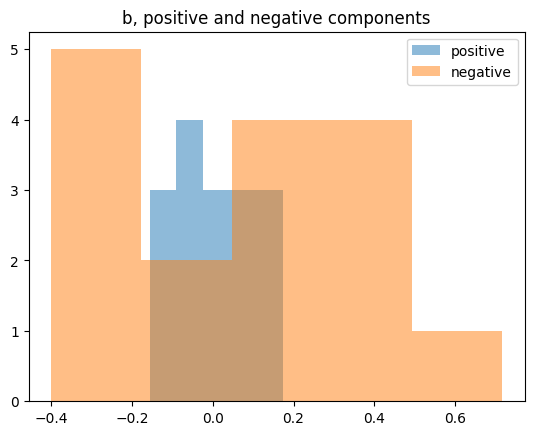

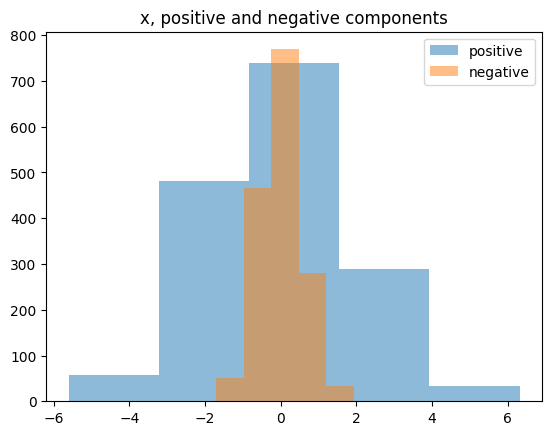

SNR [1.0, 1.0, 1.0000001192092896, 1.0, 1.0000001192092896, 1.0, 1.000000238418579, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0000001192092896, 1.0, 1.0000001192092896, 1.0000001192092896, 1.0, 1.0000001192092896, 1.000000238418579, 1.0000001192092896, 1.0, 1.0000001192092896, 1.0000001192092896, 1.0, 1.0, 1.0000001192092896, 1.0000001192092896, 1.0000001192092896, 0.9999998807907104, 1.0, 1.0, 1.0000001192092896, 1.0, 1.0, 0.9999998807907104, 1.0, 1.0, 1.0, 1.0000001192092896, 0.9999999403953552, 1.0, 1.000000238418579, 0.9999999403953552, 1.0000001192092896, 1.0, 0.9999999403953552, 1.0000001192092896, 1.0, 1.0, 1.0, 1.0000001192092896, 0.9999999403953552, 1.0000001192092896, 1.0, 1.0000001192092896, 1.0, 1.0000001192092896, 1.0000001192092896, 1.0, 1.0000001192092896, 0.9999999403953552, 1.0000001192092896, 1.0, 0.9999999403953552, 1.000000238418579, 1.0000001192092896, 1.0000001192092896, 1.0000001192092896, 1.0, 1.0000001192092896, 1.0, 1.0000001192092896, 1.000000238418579, 1.0000001192092

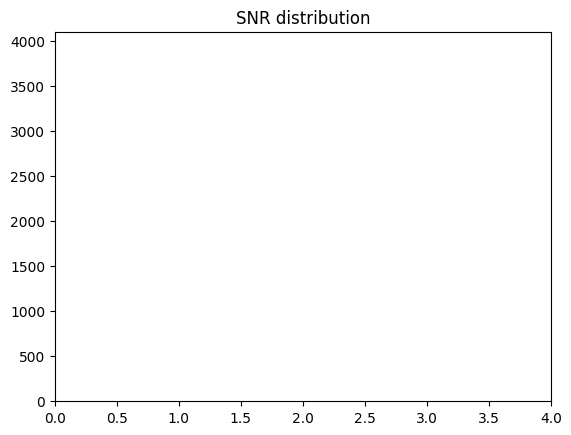

mean SNR 1.0000000507473945


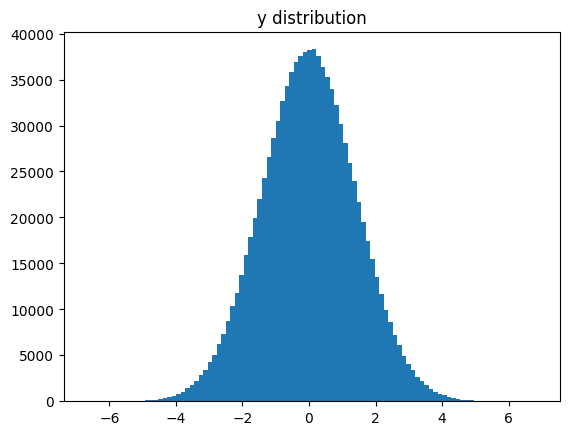

pi plus [0.5, 0.5000000596046448, 0.4999999403953552, 0.5, 0.5000000596046448, 0.5, 0.5, 0.5000000596046448, 0.5000000596046448, 0.4999999701976776, 0.5, 0.5, 0.5, 0.4999999403953552, 0.5, 0.4999999403953552, 0.5, 0.4999999701976776, 0.5000000596046448, 0.5, 0.4999999403953552, 0.4999999403953552, 0.5, 0.5, 0.4999999701976776, 0.5000000596046448, 0.4999999403953552, 0.5000000596046448, 0.4999999403953552, 0.5000000596046448, 0.5000001192092896, 0.5, 0.5000000596046448, 0.5000000596046448, 0.4999999701976776, 0.5000000596046448, 0.5, 0.5, 0.5000000596046448, 0.5000000596046448, 0.5000001192092896, 0.4999999403953552, 0.4999999403953552, 0.5000000596046448, 0.5, 0.5000000596046448, 0.5, 0.4999999403953552, 0.5000000596046448, 0.5000001192092896, 0.5000000596046448, 0.5, 0.5000000596046448, 0.49999991059303284, 0.5, 0.4999999403953552, 0.5, 0.5, 0.4999999403953552, 0.5, 0.5000000596046448, 0.5000000596046448, 0.5, 0.5, 0.5000000596046448, 0.5, 0.5000000596046448, 0.5000000596046448, 0.500

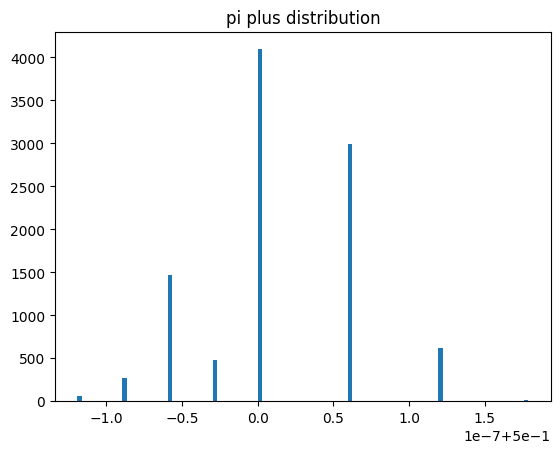

pi minus [0.5000001192092896, 0.5, 0.5, 0.5000000596046448, 0.49999988079071045, 0.49999988079071045, 0.4999999403953552, 0.5, 0.5000000596046448, 0.5000001192092896, 0.5000001192092896, 0.5, 0.5, 0.5000000596046448, 0.5000000596046448, 0.4999999403953552, 0.4999999403953552, 0.5000000596046448, 0.5000000596046448, 0.4999999403953552, 0.49999988079071045, 0.5000000596046448, 0.5, 0.4999999403953552, 0.5, 0.5, 0.5, 0.4999999403953552, 0.4999999403953552, 0.5, 0.4999999403953552, 0.4999999701976776, 0.4999999403953552, 0.5000000596046448, 0.5, 0.5000000596046448, 0.5000000596046448, 0.5, 0.5000000596046448, 0.49999991059303284, 0.5000000596046448, 0.5, 0.4999999403953552, 0.5000000596046448, 0.5000000596046448, 0.5, 0.5, 0.4999999403953552, 0.5, 0.4999999701976776, 0.5, 0.4999999403953552, 0.5, 0.4999999403953552, 0.5, 0.5, 0.5, 0.4999999403953552, 0.49999991059303284, 0.5, 0.4999999403953552, 0.5000001192092896, 0.4999999403953552, 0.5000000596046448, 0.5000000596046448, 0.4999998807907

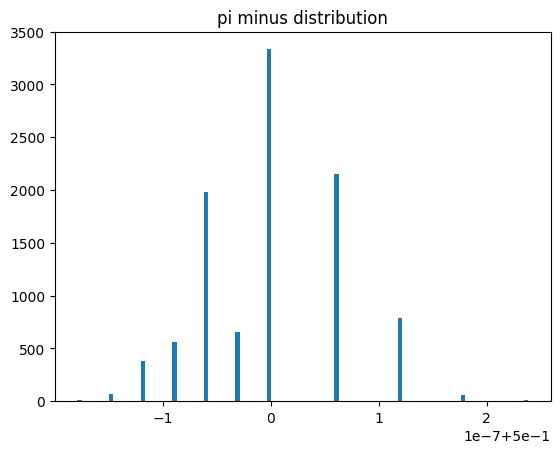

In [78]:
import matplotlib.pyplot as plt
SNRs = []
ys = []
pi_pluses = []
pi_minuses = []
# train_dataset.input_covariance_L = torch.ones_like(train_dataset.input_covariance_L) 
print ("args.sigma_xi", args.sigma_xi)
for i in range(10000):
    x, y, b = train_dataset[i]
    ys.extend(y.flatten().cpu().numpy())
    
    if i == 1:
        # print ("x", x.shape, "y", y.shape, "b", b.shape, "perm", perm.shape, perm)
        # shuffle x and b according to perm 
        # x = x[:, perm] 
        # b = b[perm]
        print ("norm plus", torch.linalg.norm(b[:16]), "norm minus", torch.linalg.norm(b[16:]))
        plt.hist (b[:16].flatten().cpu().numpy(), bins = 5, alpha = 0.5, label = "positive")
        plt.hist (b[16:].flatten().cpu().numpy(), bins = 5, alpha = 0.5, label = "negative")
        plt.title("b, positive and negative components")
        plt.legend()
        plt.show()
        # print("x", x.shape, "y", y.shape, "b", b.shape)
        plt.hist (x[:,:16].flatten().cpu().numpy(), bins = 5, alpha = 0.5, label = "positive")
        plt.hist (x[:,16:].flatten().cpu().numpy(), bins = 5, alpha = 0.5, label = "negative")
        plt.title("x, positive and negative components")
        plt.legend()

        plt.show()
    # compute projection of beta onto positive component 
    beta_plus = b.clone() 
    beta_plus[16:] = 0.0 
    # compute projection of beta onto negative component
    beta_minus = b.clone()
    beta_minus[:16] = 0.0
    # compute signal to noise ratio
     
    SNR =  torch.matmul(b.T, (train_dataset.input_covariance_L * train_dataset.input_covariance_L * b.squeeze(1) ).unsqueeze(1)) / (args.sigma_xi**2)
    # print( "b", b.T.shape, "train_dataset.input_covariance_L",  (train_dataset.input_covariance_L * train_dataset.input_covariance_L * b.squeeze(1) ).unsqueeze(1).shape)
    # w
    # print(b.flatten()[:10])
    SNRs.append(SNR.item())

    denom = torch.matmul(b.T, (train_dataset.input_covariance_L * train_dataset.input_covariance_L * b.squeeze(1) ).unsqueeze(1)).item()
    pi_plus = torch.matmul (beta_plus.T, (train_dataset.input_covariance_L * train_dataset.input_covariance_L * beta_plus.squeeze(1) ).unsqueeze(1)) / denom
    # pi minus =
    pi_minus = torch.matmul (beta_minus.T, (train_dataset.input_covariance_L * train_dataset.input_covariance_L * beta_minus.squeeze(1) ).unsqueeze(1)) / denom
    pi_pluses.append(pi_plus.item())
    pi_minuses.append(pi_minus.item())
    # print ("(b * train_dataset.input_covariance_L * train_dataset.input_covariance_L * b).sum()", (b * train_dataset.input_covariance_L * train_dataset.input_covariance_L * b).sum()) 

plt.hist(SNRs, bins = 100)
print ("SNR", SNRs[:100])
plt.title("SNR distribution")
plt.xlim(0, 4)
plt.show()
# print(train_dataset.input_covariance_L * train_dataset.input_covariance_L * 32)
print("mean SNR", np.mean(SNRs))
# print (16*(10 / (32 * np.sqrt(1)
plt.hist(ys, bins = 100)
plt.title("y distribution")
plt.show()
plt.hist(pi_pluses, bins = 100)

plt.title("pi plus distribution")
print ("pi plus", pi_pluses[:100])
plt.show()
plt.hist(pi_minuses, bins = 100)
plt.title("pi minus distribution")
print ("pi minus", pi_minuses[:100])
plt.show()

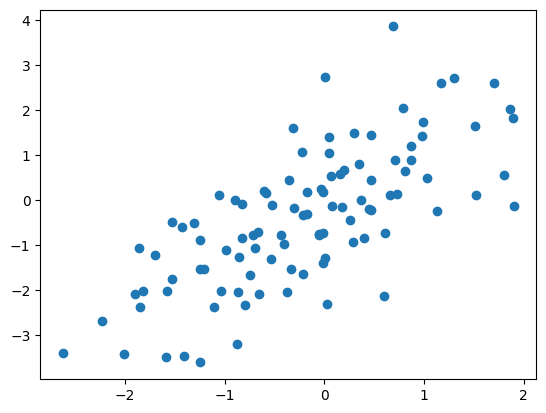

tensor([[ 0.0061],
        [-1.2458],
        [ 0.9902],
        [ 0.7039],
        [-2.6257],
        [ 0.9745],
        [-1.8965],
        [ 1.1336],
        [ 0.7882],
        [-0.9856],
        [ 0.3704],
        [-0.0140],
        [ 1.8994],
        [ 0.0278],
        [ 0.0444],
        [-0.3020],
        [-0.5264],
        [-1.7036],
        [-0.3596],
        [-0.8641],
        [-0.0189],
        [ 0.5946],
        [ 0.6603],
        [ 0.8651],
        [-0.6067],
        [-1.5933],
        [-1.5292],
        [-1.8567],
        [-0.8302],
        [ 1.8648],
        [ 1.8904],
        [-1.5314],
        [-0.2243],
        [ 0.0658],
        [ 0.1572],
        [-0.0189],
        [ 0.2568],
        [ 0.0800],
        [-1.5794],
        [-0.3138],
        [-0.8316],
        [ 0.3507],
        [-0.6643],
        [ 0.7255],
        [-1.2038],
        [ 0.4706],
        [-0.5898],
        [ 0.2890],
        [-0.2113],
        [-1.4333],
        [ 0.4645],
        [-2.2323],
        [ 0.

In [79]:
# # torch.allclose(torch.matmul(x, b), y, atol = 1e-3)
# import matplotlib.pyplot as plt
plt.scatter(torch.matmul(x, b).detach().cpu(), y.detach().cpu())
plt.show()
print (torch.matmul(x, b))
print (y)

In [9]:
# sminus = 0.1
# splus = 1.0
# data_scale = 1.0 / D
# # The proportion of eigenvalues at s₋ should be ρ₋
# rho_minus = 0.5
# # The proportion of eigenvalues at s₊ should be 1-ρ₋
# D = args.D_sum
# input_covariance = torch.eye(D)

# # Calculate number of eigenvalues for each mode 
# num_minus = int(D * rho_minus)
# num_plus = D - num_minus

# # Create diagonal matrix of eigenvalues
# eigenvalues = np.concatenate([
#     np.ones(num_plus) * splus,
#     np.ones(num_minus) * sminus
# ]) * data_scale
# # compute SNR = beta.T @ Sigma @ beta / sigma_xi^2

In [10]:
# def get_ridge_preds(seq, target, xtest, lam=1e-5):
#     seqT = seq.permute(0, 2, 1) # batch_size x D x len_context
#     ridge_matrix = torch.matmul(seqT, seq) # batch_size x D x D
#     ridge_matrix += torch.eye(ridge_matrix.size(1), device=ridge_matrix.device) * lam
#     seqT_Y = torch.matmul(seqT, target) # batch_size x D x 1
#     w_ridge = torch.linalg.solve(ridge_matrix, seqT_Y) # batch_size x D x 1
#     preds = torch.matmul(xtest, w_ridge).squeeze(-1) # batch_size x 1 x 1
#     return preds 

# def get_ridge_preds_seq(seq, target):
#     B, N, D = seq.size() 
#     preds = []
#     for _i in range(1, N):
#         preds.append(get_ridge_preds(seq[:, :_i, :], target[:, :_i, :], seq[:, _i: _i + 1, :]))
#     return torch.stack(preds, dim=1)
        
        
# def validate_gradient_descent(epoch, val_loader, model, args, criterion, device, coarse_graining="standard"):
#     # seq_lens = list(range(1, args.len_context+1, 5)) 
   
#     test_losses = [utils.AverageMeter('Loss', ':.4e') for _ in range(args.len_context)]
    
#     model.eval() # switch to eval mode
#     eps = 1e-5
    
#     with torch.no_grad():
#         for i, (seq, target, _true_beta) in enumerate(val_loader):
#             seq, target, _true_beta = seq.to(device), target.to(device), _true_beta.to(device)
            
#             B, N, D = seq.size()
#             if coarse_graining == "absbot":
#                 # true_beta: shape (B, D)
#                 true_beta = _true_beta.squeeze(2)
#                 argsort_beta_visible = torch.argsort(torch.abs(true_beta), dim=-1)[:, :args.D_visible] # sort each row of true_beta by absolute value, shape (B, D_visible)
#                 test_beta_visible = torch.gather(true_beta, dim=1, index=argsort_beta_visible) # shape (B, D_visible)
#                 x_test_visible = torch.gather(seq[:, -1, :].squeeze(1), dim=1, index=argsort_beta_visible) # shape (B, D_visible) 
                
#                 new_target = torch.matmul(x_test_visible.unsqueeze(1), test_beta_visible.unsqueeze(2)).squeeze(2) 
#                 new_target = new_target.squeeze(1)
#                 # if args.sigma_xi > 1e-5:
#                     # print  ("-args.D_visible", -args.D_visible, "argsort_beta_visible", argsort_beta_visible.shape, "test_beta_visible", test_beta_visible.shape)
#                 sigma_test_xi = torch.pow(args.sigma_xi ** 2 + torch.matmul(true_beta.unsqueeze(1), true_beta.unsqueeze(2)) \
#                                         - torch.matmul(test_beta_visible.unsqueeze(1), test_beta_visible.unsqueeze(2))+eps, 0.5).squeeze(2).squeeze(1) # shape (B)
#                 # print ("sigma_test_xi", sigma_test_xi)
#                 new_target += torch.randn(new_target.size(0), device=device) * sigma_test_xi # shape (B, 1) 
#                 target[:, -1, 0] = new_target
                
#             elif coarse_graining == "abstop":
#                 true_beta = _true_beta.squeeze(2) # shape (B, D)
#                 # print ("true_beta", true_beta.shape)
#                 argsort_beta_visible = torch.argsort(torch.abs(true_beta), dim=-1)[:, -args.D_visible:] # sort each row of true_beta by absolute value, shape (B, D_visible)
#                 # test_beta_visible = true_beta[argsort_beta_visible] # take top D_visible betas, shape (B, D_visible) 
#                 test_beta_visible = torch.gather(true_beta, dim=1, index=argsort_beta_visible) # shape (B, D_visible)
#                 x_test_visible = torch.gather(seq[:, -1, :].squeeze(1), dim=1, index=argsort_beta_visible) # shape (B, D_visible) 
                
#                 # target = x_test_visible  @ test_beta_visible + np.random.randn(N_test) * sigma_test_xi
#                 new_target = torch.matmul(x_test_visible.unsqueeze(1), test_beta_visible.unsqueeze(2)).squeeze(2) 
#                 new_target = new_target.squeeze(1)
#                 # if args.sigma_xi > 1e-5:
#                     # print  ("-args.D_visible", -args.D_visible, "argsort_beta_visible", argsort_beta_visible.shape, "test_beta_visible", test_beta_visible.shape)
#                 sigma_test_xi = torch.pow(args.sigma_xi ** 2 + torch.matmul(true_beta.unsqueeze(1), true_beta.unsqueeze(2)) \
#                                         - torch.matmul(test_beta_visible.unsqueeze(1), test_beta_visible.unsqueeze(2))+eps, 0.5).squeeze(2).squeeze(1) # shape (B)
#                 # print ("sigma_test_xi", sigma_test_xi)
#                 new_target += torch.randn(new_target.size(0), device=device) * sigma_test_xi # shape (B, 1) 
#                 # print ("new_target", new_target, "sigma_test_xi", sigma_test_xi )
#                 target[:, -1, 0] = new_target

                
            

            
#             # print ("seq", seq.shape, "target", target.shape)
#             output = model(seq, target) 
#             # print ("seq", seq.shape, "target", target.shape, "output", output.shape )
#             preds = output[:, ::2, :]
#             # distance to ridge_preds 
#             # if coarse_graining == "standard":
#             #     ridge_preds = get_ridge_preds_seq(seq, target) # shape: (B, N-1, 1)
#             #     ridge_loss = (ridge_preds - target[:, 1:, :]).pow(2).mean(dim=0)
#             #     dist_to_ridge = (preds[:,1:, :] - ridge_preds).pow(2).mean(dim=0)
#             #     print ("ridge_loss", ridge_loss, "dist_to_ridge", dist_to_ridge.shape, dist_to_ridge)
                
#             loss = (preds - target).pow(2).squeeze(-1).mean(dim=0) 
#             print ("test preds", preds.shape, "test target", target.shape, "test loss", loss.shape)
            
#             [test_losses[_].update(loss[_].item(), target.size(0)) for _ in range(N)]
#             # acc1 = utils.accuracy(output, seq_target, topk=[1])
#             # test_top1[seq_len].update(acc1[0], target.size(0))
#             # acc1 = torch.mean(((output.squeeze(1) * (seq_target*2-1)) > 0).float()).item()
#             # test_top1[seq_len].update(acc1, target.size(0))

#     return test_losses 

In [11]:
import pickle
# import matplotlib.pyplot as plt
exp_name = f"./cache/{args.wandb_group_name}_{args.fileprefix}_{time.time()}.pkl"
for epoch in range(args.epochs):
    # icl_indistribution_losses = validate_gradient_descent(epoch, icl_test_loader, model, args, criterion, device, coarse_graining="standard")
    # icl_outdistribution_losses = validate_gradient_descent(epoch, icl_test_loader, model, args, criterion, device, coarse_graining=args.coarse_graining)
    # iwl_indistribution_losses = validate_gradient_descent(epoch, iwl_test_loader, model, args, criterion, device, coarse_graining="standard")
    # iwl_outdistribution_losses = validate_gradient_descent(epoch, iwl_test_loader, model, args, criterion, device, coarse_graining=args.coarse_graining)
    
    model.train() # switch to train mode
    losses = utils.AverageMeter('Loss', ':.4e')
    ridge_losses = utils.AverageMeter('Ridge Loss', ':.4e')
    top1 = utils.AverageMeter('Acc@1', ':6.2f')

 
    for i, (seq, target, _) in enumerate(train_loader):
        optimizer.zero_grad()
        seq, target = seq.to(device), target.to(device)
        # print ("seq", seq.shape, "target", target.shape)
        output = model(seq, target) 
        # print ("seq", seq.shape, "target", target, "output", output )
        preds = output[:, ::2, :] # shape: (B, L, 1)
        loss = criterion(preds, target)
        
        # batch_first_seq, batch_first_target = seq[0, :-1, :], target[0, :-1, 0]
        # print ("batch_first_seq", batch_first_seq.shape, "batch_first_target", batch_first_target.shape)
        # ridge = utils.Ridge(alpha=1e-9,fit_intercept=True) 
        # ridge.fit(batch_first_seq, batch_first_target)
        # val_loss = criterion(ridge.predict(seq[0, [-1], :]), target[0, -1, 0])
        # print ("loss", loss)
        # ridge_losses.update(val_loss.item(), 1) 
        # compute ridge loss on first sequence
        
        
        loss.backward()
        optimizer.step()
        losses.update(loss.item(), target.size(0)) 
        # acc1 = utils.accuracy(output, (seq_target), topk=[1])
        # print ("output", output.shape, output[0], seq_target[0], loss, acc1, model.temperature)
        # top1.update(acc1[0], target.size(0))
        # acc1 = torch.mean(((output.squeeze(1) * (seq_target*2-1)) > 0).float()).item()
        # top1.update(acc1, target.size(0))
        # step scheduler
        scheduler.step()
    print ("loss" , loss, "preds", preds.shape, "target", target.shape)
    

    # save metrics
    # print("output",  torch.argsort(output, dim=-1), "target", target )
    # print("Current average loss", losses.avg, top1.avg, "epoch", epoch) 
    # seen_val_losses, seen_val_top1 = validate_gradient_descent(icl_loader, seen_projs_permutations_loader, model, args, criterion, device)
    
    # Compute unseen val loss
    # unseen_val_losses, unseen_val_top1 = validate_gradient_descent(icl_loader, seen_projs_permutations_loader, model, args, criterion, device)
    logs = {
            "train_loss": losses.avg,
            "epoch": epoch,
            "lr": optimizer.param_groups[0]['lr'],
            # "icl_indistribution_loss": icl_indistribution_losses.avg,
            # "icl_outdistribution_loss": icl_outdistribution_losses.avg,
            # "iwl_indistribution_loss": iwl_indistribution_losses.avg,
            # "iwl_outdistribution_loss": iwl_outdistribution_losses.avg,
        }
    # for _ in range(args.len_context):
    #     logs[f"icl_indistribution_loss_{_}"] = icl_indistribution_losses[_].avg
    #     logs[f"icl_outdistribution_loss_{_}"] = icl_outdistribution_losses[_].avg
    #     logs[f"iwl_indistribution_loss_{_}"] = iwl_indistribution_losses[_].avg
    #     logs[f"iwl_outdistribution_loss_{_}"] = iwl_outdistribution_losses[_].avg
    
    # print(logs) 
    if args.wandb_log:
        wandb.log(logs)
    else:
        record["logs"].append(logs)
    
 
    # save phi_xt_list_epoch 
    
    
    if epoch % 10 == 0 and args.wandb_log != True:
        record["model"] = copy.deepcopy(model.state_dict())  
        with open(exp_name, "wb") as f:
            pickle.dump(record, f)
        # print (record["model"])
record["model"] = copy.deepcopy(model.state_dict())  
if args.wandb_log != True:
    with open(exp_name, "wb") as f:
        pickle.dump(record, f)

/scratch/gpfs/qanguyen/learning_to_learn/l2l/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


KeyboardInterrupt: 